## Eye diseases Classification

Eye disease classification is a research area that focuses on developing algorithms and models to accurately classify different types of eye diseases based on medical imaging data. It plays a critical role in assisting ophthalmologists and healthcare professionals in effectively diagnosing and treating eye diseases.

The primary objective of eye disease classification is to leverage machine learning and computer vision techniques to analyze medical images and detect the four diseases: cataract, diabetic retinopathy, glaucoma, normal.

- The dataset consists of Normal, Diabetic Retinopathy, Cataract and Glaucoma retinal images where each class have approximately 1000 images. These images are collected from various sorces like IDRiD, Oculur recognition, HRF etc.

- Diabetic retinopathy: Diabetic retinopathy is a complication of diabetes that affects the blood vessels in the retina. It can cause vision loss, including blurred or distorted vision, and in severe cases, lead to blindness. Early detection, regular eye exams, and proper management of diabetes are crucial for preventing and managing this condition.

- Cataracts: Cataract is a common age-related eye condition characterized by the clouding of the lens, leading to blurry vision and visual impairment. It can be treated surgically by replacing the cloudy lens with an artificial one, restoring clear vision and improving quality of life.

- Glaucoma: Glaucoma is a group of eye diseases that damage the optic nerve, often due to increased fluid pressure in the eye. It gradually leads to vision loss, starting with peripheral vision and potentially progressing to complete blindness. Timely diagnosis, treatment, and ongoing monitoring are vital for preserving vision and preventing irreversible damage.

## Import Libraries

In [2]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

## Class for Loading and Splitting Datasets

In [ ]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
   
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
  
    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)
   
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [ ]:
dataDir=r"C:\Users\Selvam\OneDrive\Desktop\project\eye-diseases-classification\dataset"

In [ ]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

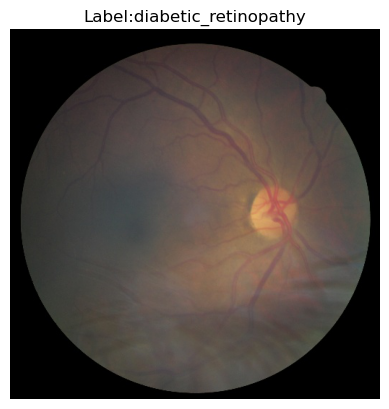

In [ ]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']
    
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

## Function for Data Augmentation

In [ ]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'
    

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])
          
    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
          
    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
   
    print("Shape of augmented training images:", train_generator.image_shape)
          
    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
         
    print("Shape of validation images:", valid_generator.image_shape)
          
    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )
          
    print("Shape of test images:", test_generator.image_shape)
          
    return train_generator, valid_generator, test_generator

In [ ]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


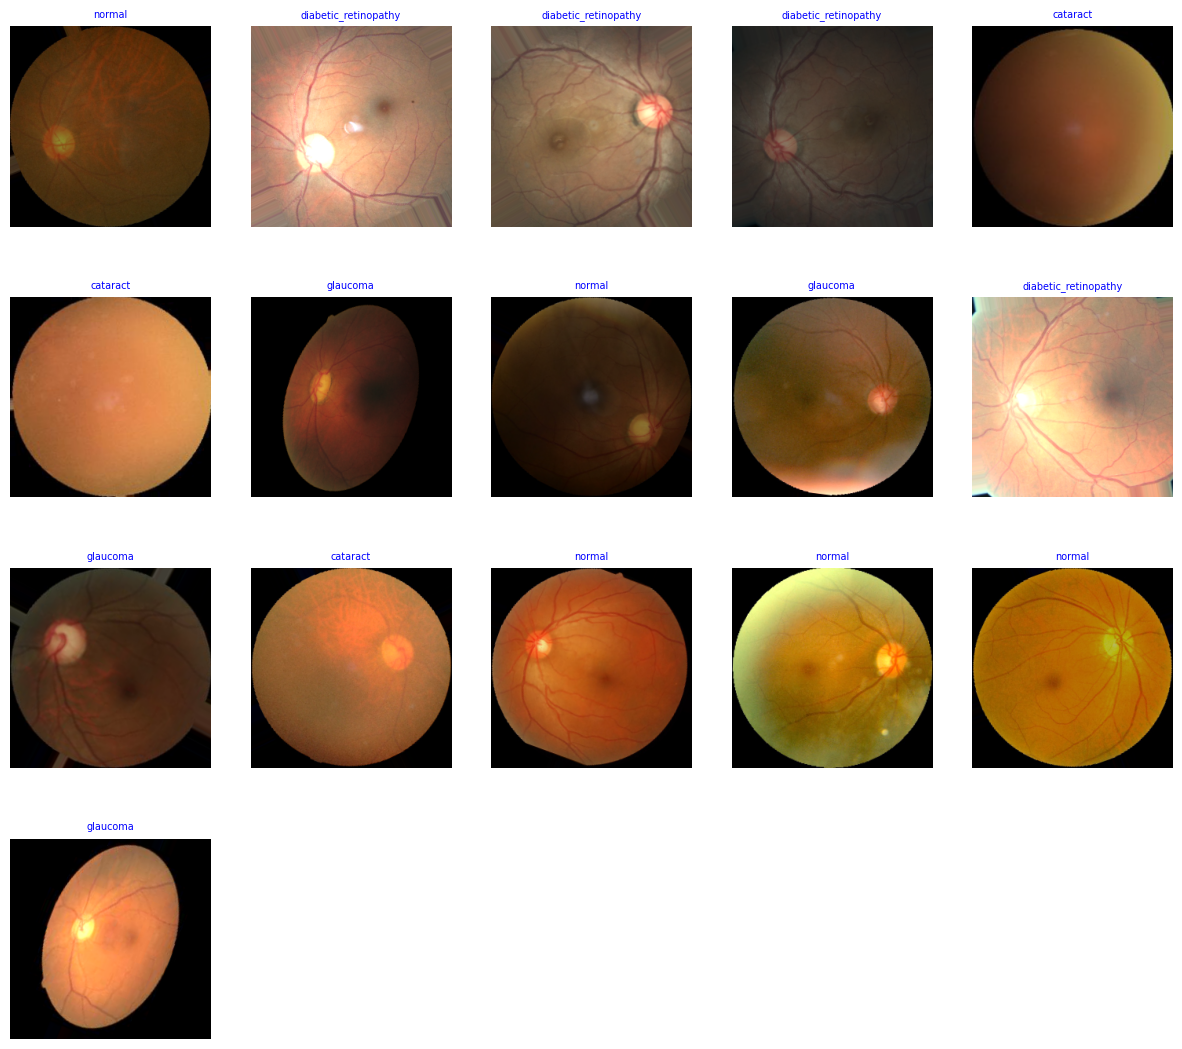

In [ ]:
def show_images(gen):
      
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)       
    sample = min(length, 20)   
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)

## Download and compile the model

In [ ]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the model

In [ ]:
history = model.fit(
    train_augmented,
    epochs=15, 
    validation_data=valid_augmented,
    )

Epoch 1/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.6631 - loss: 4.3061 - val_accuracy: 0.7299 - val_loss: 1.0384
Epoch 2/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.7576 - loss: 0.9243 - val_accuracy: 0.7180 - val_loss: 0.9280
Epoch 3/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 236s 1s/step - accuracy: 0.7627 - loss: 0.7863 - val_accuracy: 0.7180 - val_loss: 0.8508
Epoch 4/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7634 - loss: 0.7513 - val_accuracy: 0.6422 - val_loss: 0.9908
Epoch 5/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7687 - loss: 0.7286 - val_accuracy: 0.7441 - val_loss: 0.7820
Epoch 6/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7803 - loss: 0.7074 - val_accuracy: 0.7512 - val_loss: 0.7846
Epoch 7/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 241s 1s/step - accuracy: 0.7567 - loss: 0.7116 - val_accuracy: 0.7488 - val_loss: 0.7836
Epoch 8/15
211/211 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.7803 - loss: 0.6898 - val_accu

## Plot the Accuracy and Loss

Training Accuracy: 0.7892084121704102
Validation Accuracy: 0.7298578023910522


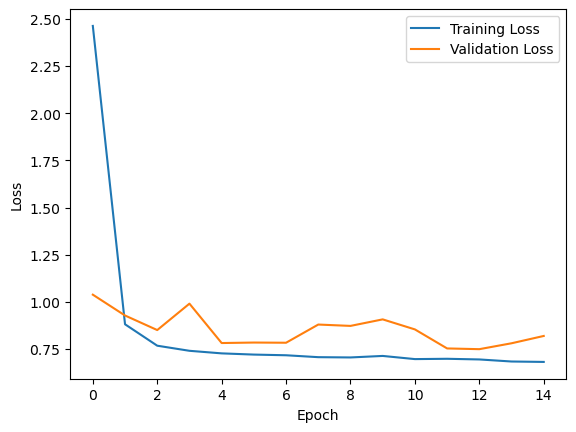

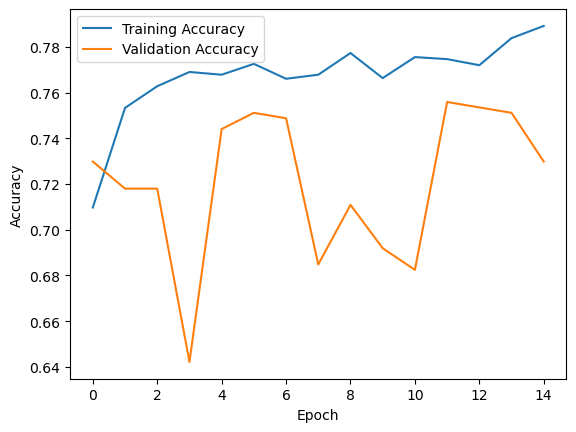

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Display the Actual and Predicted images

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


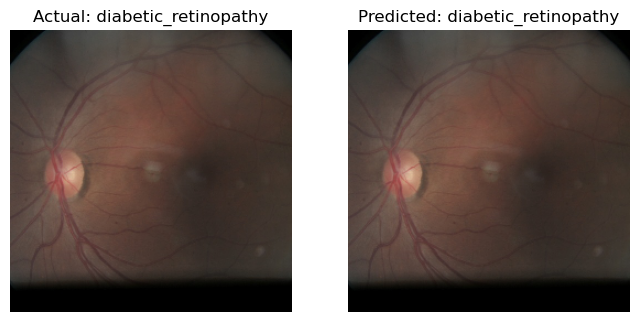

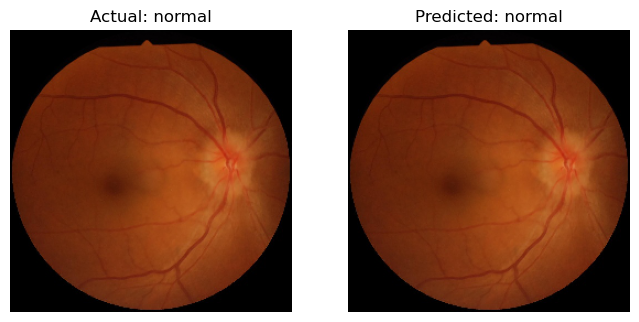

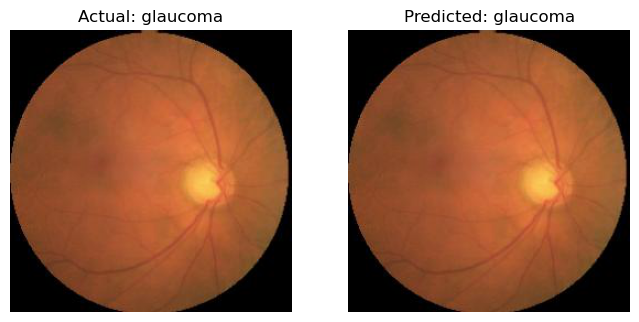

In [ ]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)

## Confusion Matrix

27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step 


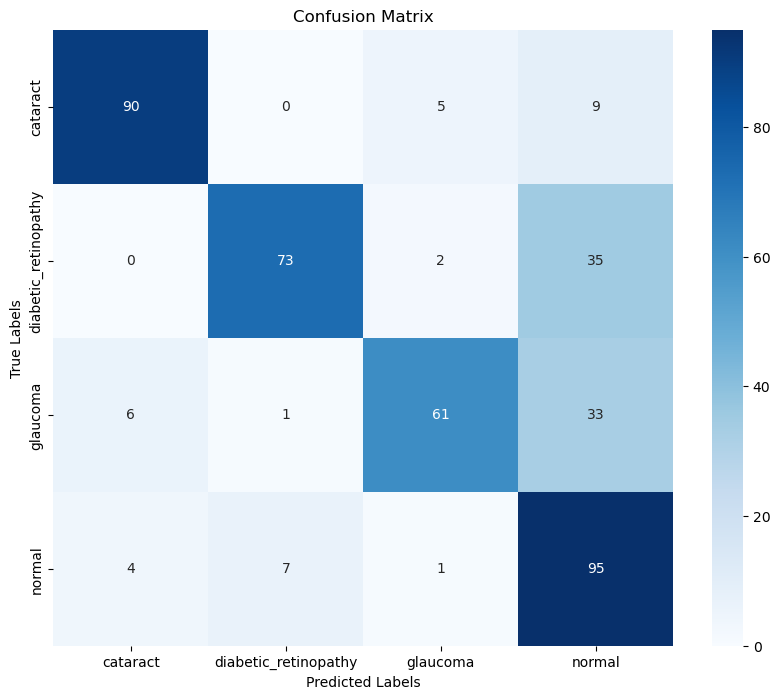

                      precision    recall  f1-score   support

            cataract       0.90      0.87      0.88       104
diabetic_retinopathy       0.90      0.66      0.76       110
            glaucoma       0.88      0.60      0.72       101
              normal       0.55      0.89      0.68       107

            accuracy                           0.76       422
           macro avg       0.81      0.76      0.76       422
        weighted avg       0.81      0.76      0.76       422



In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Predict the classes for the test data
test_labels = test_augmented.classes
predictions = model.predict(test_augmented)
predicted_classes = np.argmax(predictions, axis=1)

# Get the class labels
class_labels = list(train_augmented.class_indices.keys())

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(test_labels, predicted_classes, target_names=class_labels))
